In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string

In [2]:
origin_dataset = pd.read_csv("raw_data/text_emotion_Dataset.csv")

# Text Process: Preparation

In [3]:
emotion_dataset = origin_dataset[['text','label']].copy()
emotion_dataset['label'] = emotion_dataset['label'].astype('category')
emotion_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   text    416809 non-null  object  
 1   label   416809 non-null  category
dtypes: category(1), object(1)
memory usage: 3.6+ MB


In [4]:
label_mapping = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}
# emotion_dataset['emotion_label'] = emotion_dataset['label'].map(label_mapping)

In [5]:
def preprocessing_text(text):
    text = text.str.lower()
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    text = text.str.replace(r'\[.*?\]', '', regex=True)
    text = text.str.replace(r'<.*?>', '', regex=True)
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace(r'\s+', ' ', regex=True)
    text = text.str.replace(r'\d+', '', regex=True)
    text = text.str.replace(r'\b(?:a|href|http|https|www)\b', '', regex=True)
    text = text.str.strip()
    return text

In [6]:
emotion_dataset['text'] = preprocessing_text(emotion_dataset['text'])


# Model: Logisitc Regression

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [8]:
X = emotion_dataset['text']
y = emotion_dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (333447,)
y train: (333447,)
X test: (83362,)
y test: (83362,)


In [9]:
tfidf_vectorizer = TfidfVectorizer()
vectorize_XTrain = tfidf_vectorizer.fit_transform(X_train)
vectorize_Xtest = tfidf_vectorizer.transform(X_test)

In [10]:
logistics_reg = LogisticRegression()
logistics_reg.fit(vectorize_XTrain,y_train)

/home/jason/.pyenv/versions/3.10.6/envs/Emotion-Text-Detection/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
predict_test = logistics_reg.predict(vectorize_Xtest)

Logisitic Regression scoring: 0.9007221515798566


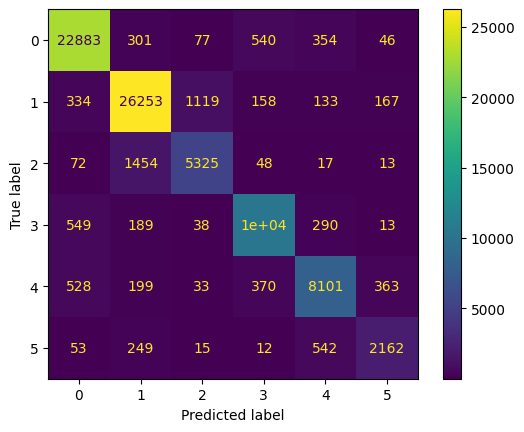

In [12]:
score_comparison = accuracy_score(y_test,predict_test)
print(f"Logisitic Regression scoring: {score_comparison}")
ConfusionMatrixDisplay.from_predictions(y_test,predict_test)

## Find optimize logistics parameter

In [13]:
from sklearn.model_selection import GridSearchCV

In [18]:
enhanced_logreg = LogisticRegression()
param_grid = [
    {
        # 'max_iter': [1000, 2000, 3000],
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga']
    }
    # ,
    # {
    #     'max_iter': [1000, 2000, 3000],
    #     'C': [0.01, 0.1, 1, 10, 100],
    #     'penalty': ['l2'],
    #     'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
    # },
    # {
    #     'max_iter': [1000, 2000, 3000],
    #     'C': [0.01, 0.1, 1, 10, 100],
    #     'penalty': ['elasticnet'],
    #     'solver': ['saga']
    # }
]

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=enhanced_logreg,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [20]:
# grid_search.fit(vectorize_XTrain, y_train)
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# print("Best Parameters:", best_params)

0.9076197787960941


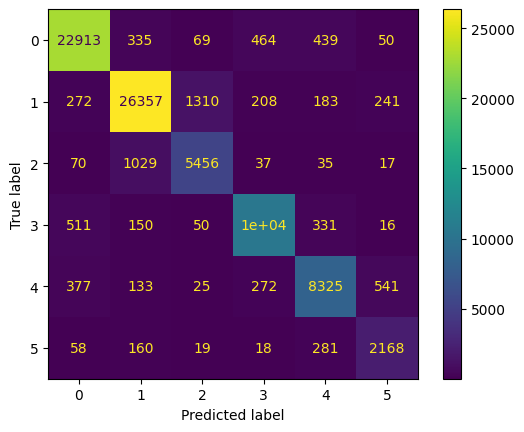

In [23]:
LogModel_best_param = LogisticRegression(C=1 ,penalty='l1',solver='liblinear', max_iter = 1000)
LogModel_best_param.fit(vectorize_XTrain, y_train)
LogModel_best_result = LogModel_best_param.predict(vectorize_Xtest)
print(accuracy_score(LogModel_best_result, y_test))
ConfusionMatrixDisplay.from_predictions(LogModel_best_result, y_test)

In [30]:
test_case = ["Oh my god!"]
test_case_vec = tfidf_vectorizer.transform(test_case)
print(LogModel_best_param.predict(test_case_vec))

[1]


In [32]:
import pickle

with open('log_model.pkl', 'wb') as model_file:
    pickle.dump(LogModel_best_param, model_file)

print("Model saved successfully!")

with open('tfidf_vectorizer', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("Vectorization saved successfully!")

Model saved successfully!
Vectorization saved successfully!
